# Simulate spectrum extension model 

The spectrum extension model is described in SM Section 5.1 of the paper. 

The transition rates between $X$ and $Y$ are: 

$P(Y \rightarrow X) = (1-s_i) m + s_i f(x)$, where $s_i$ is the degree to which a person is a social learner

$P(X \rightarrow Y) =  (1-s_i) (1-m) + s_if(1-x)$

s = 0 -> purely individual learning

s = 1 -> purely social learning

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import matplotlib.lines as mlines
import pandas as pd
import scipy.stats as stats

# import functions in my_functions
import ipynb.fs.defs.my_functions as myfun

In [6]:
def update(opinion, sList, m, alpha):
    """
    Function that updates opinion of each person in 1 time step using update function
    """    
    N = len(opinion)
    x = np.sum(opinion)/N # portion of people with opinion 1

    p_01 = (1-sList)*m + sList*myfun.f(x, alpha) # transition rates from Y (0) to X (1)
    p_10 = (1-sList)*(1.-m) + sList*myfun.f(1.-x, alpha) # transition rate from X (1) to Y (0). 
        
    # update opinion 
    idx0 = (opinion == 0)
    idx1 = (opinion == 1)
    
    Dice = np.random.uniform(size = N)
    opinion[idx0 & (Dice < p_01)] = 1 # set those with value 0 to 1 with probability m. 
    opinion[idx1 & (Dice < p_10)] = 0 # set those with value 0 to 1 with probability m. 
    
    return opinion


def run_till_converge(opinion, sList, m, alpha, tmax):
    """
    Run simulation until convergence
    """
    xList = []
    N = len(opinion)
    x0 = np.sum(opinion)/N
    
    for t in range(tmax): 
        x = np.sum(opinion)/N # portion of people with opinion 1
        xList.append(x)
        opinion = update(opinion, sList, m, alpha) 
        converge, avg, astd = myfun.checkConverge(xList) # check if simulation converged
        if converge ==1: 
            x_ss = avg
            break
    return {"x_ss": avg, "x0": x0, "m": m, "alpha": alpha, "tConv":t}


# --- Parameters to do a test run of 1 trial--- 
N = 10000
sList = np.random.uniform(size = N) # get the distribution of r. uniform betwee 0 and 1
x0 = 0.4 # unitial portion of people with opinion x
opinion = (np.random.uniform(size = N) < x0)*1 # vector storing opinion of each person

m = 0.2
alpha = 1.5
tmax = 1000

out = run_till_converge(opinion,sList, m, alpha, tmax)

## Loop through parameters

In [8]:
def run_multi(s, mList, x0List):
    """
    run multiple trails of different m and x0 parameters, with the same s distribution
    """

    res = []
    N = len(s)
    for x0 in x0List:
        for m in mList:
            opinion = (np.random.uniform(size = N) < x0)*1 # initialize opinion with x0. 
            out = run_till_converge(opinion,s, m, alpha, tmax)
            res.append(out)
    return pd.DataFrame(res)

# number of individuals
N = 10000

# get the distribution of r. uniform betwee 0 and 1
s1 = np.random.uniform(size = N) 

mList = np.linspace(0, 1, 30)
x0List = np.array([0.1, 0.5, 0.9])

# run the uniform case
res1 = run_multi(s1,mList, x0List)


In [9]:

# skewed s distribution, beta distribution. Larger a > b is skewed to the right
a = 5
b = 1

s2 = np.random.beta(a, b, size = N) 

mList = np.linspace(0, 1, 30)

x0List = np.array([1, 0])

# run simulation 
res2 = run_multi(s2,mList, x0List)


In [10]:

# s distributed as truncated normal between 0 and 1
lower, upper = 0, 1
mu, sigma = 0.5, 0.2
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
s3 = X.rvs(N)

mList = np.linspace(0, 1, 30)
x0List = np.array([0.1, 0.5, 0.9])

# run the uniform case
res3 = run_multi(s3,mList, x0List)

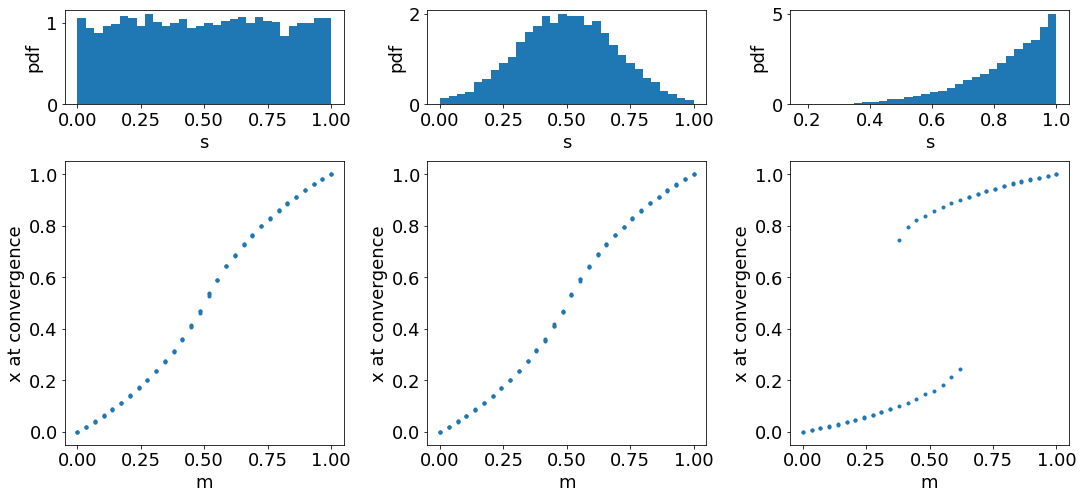

In [11]:
# Plot results

bins = 30
row = 2
col = 3

def plot_r_hist(ax,s, bins):
    ax.hist(s, bins, density = True)
    ax.set_ylabel("pdf")
    ax.set_xlabel("s")
    
def plot_m_bif(ax, res):
    # plot bifurcation diagram with respect to m
    ax.plot(res.m, res.x_ss, ".")
    ax.set_xlabel("m")
    ax.set_ylabel("x at convergence")
    
    

fig, ax= plt.subplots(row,  col, gridspec_kw={'height_ratios': [1,3]}, figsize = (18, 8))
plot_r_hist(ax[0,0], s1, bins)
plot_m_bif(ax[1, 0], res1)

plot_r_hist(ax[0,2], s2, bins)
plot_m_bif(ax[1, 2], res2)

plot_r_hist(ax[0,1], s3, bins)
plot_m_bif(ax[1, 1], res3)

fig.subplots_adjust(wspace=0.3, hspace=0.3 )

plt.show()
